In [1]:
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
left = []
right = []

with open('motion_gui_logs_rachel_1.pickle', 'rb') as f:
    file = pickle.load(f)
    
    event_array = file['EVENT_LOG']
    signal_array = file['DATA_LOG']
    
    j = 0
    for i in tqdm(range(len(event_array)-1)):
        
        event_data = vars(event_array[i])
        next_event_data = vars(event_array[i+1])
        
        # initial time for that event
        time_0 = event_data['timestamp']
        
        # array to store signal for that event
        event_signal = np.array([])
        
        # loop through signal array. While timestamp is less than timestamp
        # of the next event, add it to the current event signal
        while signal_array[j]['time'] <= next_event_data['timestamp']:
            
            # number of points at that timestamp
            n_samples = signal_array[j]['data'].shape[1]
            
            # spread out time between this timestamp and the next
            times = np.linspace(signal_array[j]['time'], signal_array[j+1]['time'], n_samples)
            
            # map each time to a list of channel values
            for time, channel_values in zip(times, signal_array[j]['data'][:8].T):

                # signal at this event timestamp
                signal_at_time = np.array([])

                # populate the current signal array
                for channel in channel_values:
                    point = np.array([time - time_0, channel])
                    signal_at_time = np.vstack((signal_at_time, point)) \
                                            if signal_at_time.size else point
                    
                # add another dimension to signal_at_time for formatting
                signal_at_time = np.expand_dims(signal_at_time, axis=1)
                    
                # add the signal at the current time to the event signal
                event_signal = np.concatenate((event_signal, signal_at_time), axis=1) \
                                            if event_signal.size else signal_at_time
            
            # next timestamp in signal array
            j += 1
            
        # add it to either left or right data
        if event_signal.size == 0:
            continue
  
        if event_data['task'] == 'LEFT':
            left.append(event_signal)
                
        elif event_data['task'] == 'RIGHT':
            right.append(event_signal)
                
    # add remaining not needed since last event is end


100%|█████████████████████████████████████████| 184/184 [00:06<00:00, 27.76it/s]


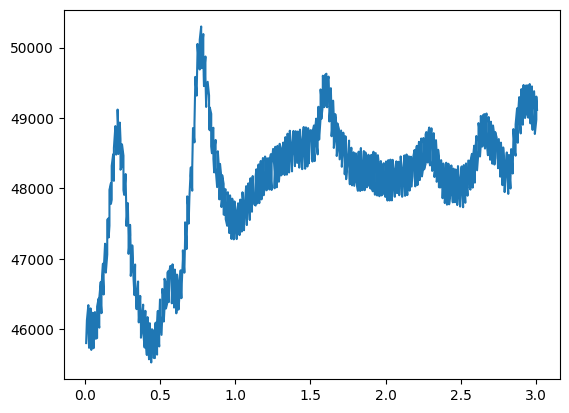

In [3]:
# format: left[event_number][channel_number][time] = [time, value]
plt.plot(left[3][4][:, 0], left[3][4][:, 1])

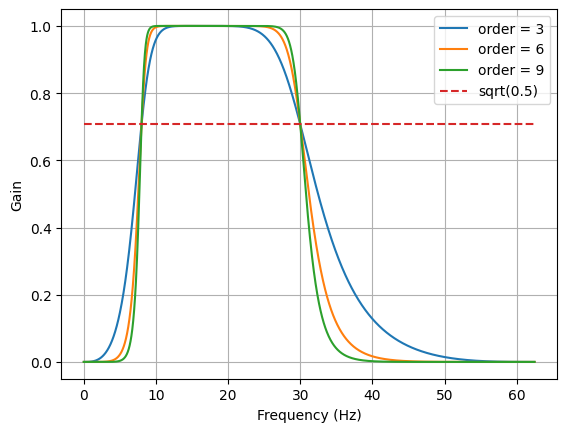

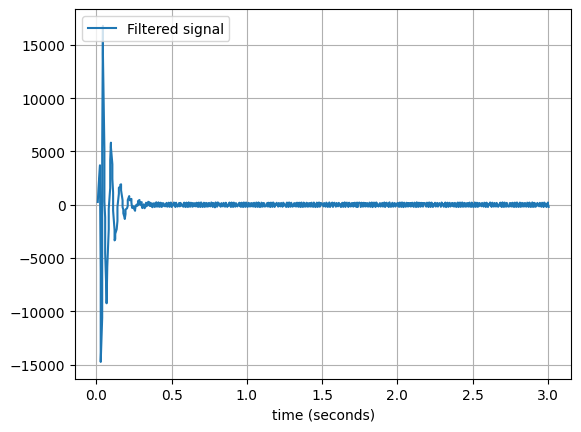

In [4]:
# Butterworth Bandpass Filter
# Taken from https://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter

from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


from scipy.signal import freqz

# Sample rate and desired cutoff frequencies (in Hz).
fs = 125
lowcut = 8
highcut = 30

# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()
for order in [3, 6, 9]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, fs=fs, worN=2000)
    plt.plot(w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

# Let's extract a single channel from a single event
t = left[3][4][:, 0]
x = left[3][4][:, 1]

# Filter the signal
y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)

plt.figure()
plt.plot(t, y, label='Filtered signal')
plt.xlabel('time (seconds)')
# plt.hlines([-a, a], 0, T, linestyles='--')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

plt.show()

In [5]:
# Wavelet Packet Transform

import pywt

lvl=6
wvlet='db6'

wp = pywt.WaveletPacket(data=y, wavelet=wvlet, mode='symmetric')

In [6]:
print(pywt.scale2frequency(wvlet, lvl) * 125) # sampling frequency is 125 Hz
print([node.path for node in wp.get_level(lvl, 'freq')]) # print paths by frequency

15.151515151515152
['aaaaaa', 'aaaaad', 'aaaadd', 'aaaada', 'aaadda', 'aaaddd', 'aaadad', 'aaadaa', 'aaddaa', 'aaddad', 'aadddd', 'aaddda', 'aadada', 'aadadd', 'aadaad', 'aadaaa', 'addaaa', 'addaad', 'addadd', 'addada', 'adddda', 'addddd', 'adddad', 'adddaa', 'adadaa', 'adadad', 'adaddd', 'adadda', 'adaada', 'adaadd', 'adaaad', 'adaaaa', 'ddaaaa', 'ddaaad', 'ddaadd', 'ddaada', 'ddadda', 'ddaddd', 'ddadad', 'ddadaa', 'ddddaa', 'ddddad', 'dddddd', 'ddddda', 'dddada', 'dddadd', 'dddaad', 'dddaaa', 'dadaaa', 'dadaad', 'dadadd', 'dadada', 'daddda', 'dadddd', 'daddad', 'daddaa', 'daadaa', 'daadad', 'daaddd', 'daadda', 'daaada', 'daaadd', 'daaaad', 'daaaaa']


In [7]:
wp['aaaaaa'].data

array([-4.87981888e+03, -4.40277300e+03, -4.53262461e+03, -4.76174560e+03,
       -5.64159362e+03, -5.13204617e+03, -4.09297815e+03, -4.89764427e+03,
       -4.72407866e+03, -2.92730222e+02, -8.64298672e-02,  2.26033963e-02,
       -5.77854833e-03, -6.47821910e-03, -3.32503506e-03,  4.27159281e-02,
       -4.96431820e-01,  3.06324088e+00, -1.03510000e+01,  2.59664116e+01,
       -7.64648302e+01, -1.83404194e+02])

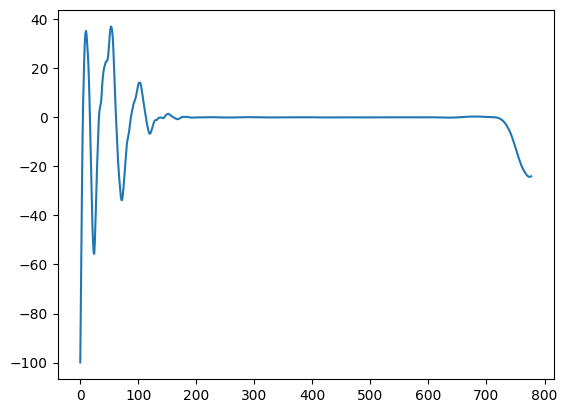

In [8]:
new_wp = pywt.WaveletPacket(data=None, wavelet=wvlet, mode='symmetric')

# Add 0-30 Hz.
# TODO: Figure out how to get Mu (8-14 Hz) and Beta (15-30 Hz).
# currently running into an error with maximum decomposition level

new_wp['aaaaaa'] = wp['aaaaaa'].data
new_wp['aaaaad'] = wp['aaaaad'].data

filtered = new_wp.reconstruct(update=False)

plt.plot(filtered)

In [9]:
# The rest of this code is just taken from https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/
# don't know how any of it works but seems to kind of work?

from scipy.fftpack import fft
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

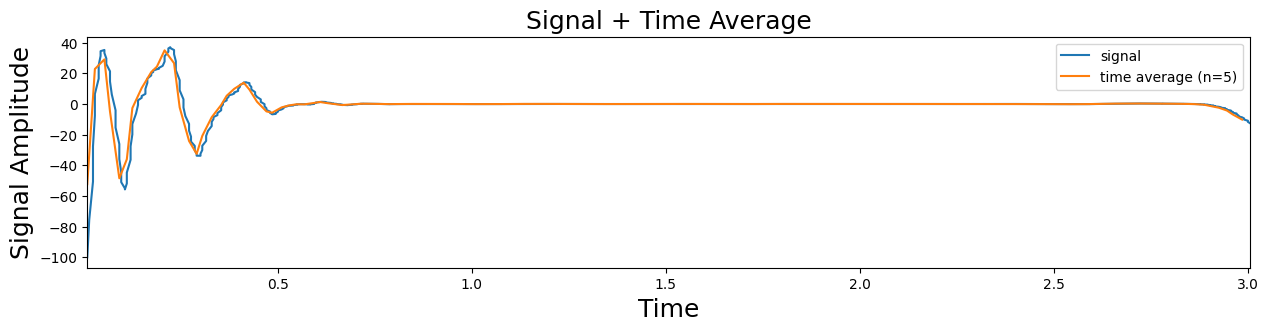

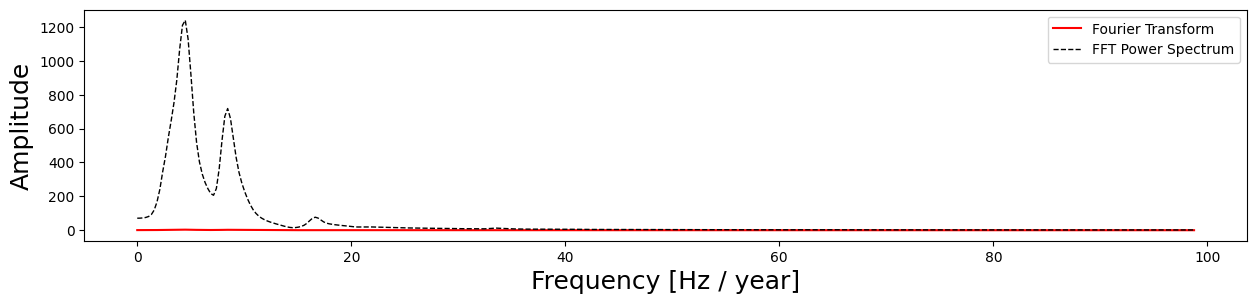

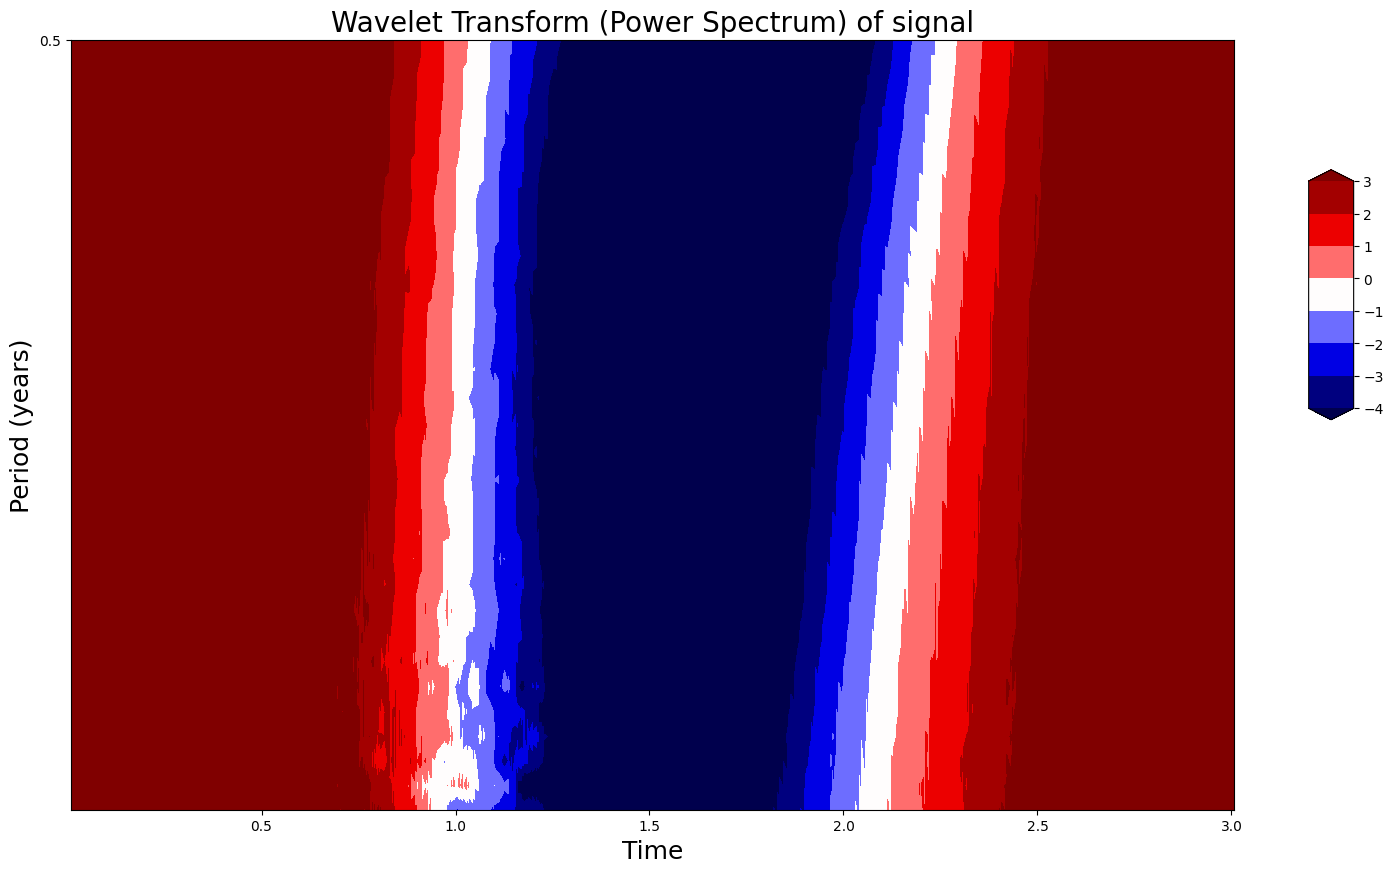

In [10]:
def plot_wavelet(time, signal, scales, 
                 waveletname = 'cmor1.5-1', # bandwidth frequency, center frequency. but don't know what that means so lets just try this
                 cmap = plt.cm.seismic, 
                 title = 'Wavelet Transform (Power Spectrum) of signal', 
                 ylabel = 'Period (years)', 
                 xlabel = 'Time'):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)
    
    fig, ax = plt.subplots(figsize=(15, 10))
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    
    cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
    fig.colorbar(im, cax=cbar_ax, orientation="vertical")

    
    plt.show()
    
def get_ave_values(xvalues, yvalues, n = 5):
    signal_length = len(xvalues)
    if signal_length % n == 0:
        padding_length = 0
    else:
        padding_length = n - signal_length//n % n
    xarr = np.array(xvalues)
    yarr = np.array(yvalues)
    xarr.resize(signal_length//n, n)
    yarr.resize(signal_length//n, n)
    xarr_reshaped = xarr.reshape((-1,n))
    yarr_reshaped = yarr.reshape((-1,n))
    x_ave = xarr_reshaped[:,0]
    y_ave = np.nanmean(yarr_reshaped, axis=1)
    return x_ave, y_ave
 
def plot_signal_plus_average(time, signal, average_over = 5):
    fig, ax = plt.subplots(figsize=(15, 3))
    time_ave, signal_ave = get_ave_values(time, signal, average_over)
    ax.plot(time, signal, label='signal')
    ax.plot(time_ave, signal_ave, label = 'time average (n={})'.format(5))
    ax.set_xlim([time[0], time[-1]])
    ax.set_ylabel('Signal Amplitude', fontsize=18)
    ax.set_title('Signal + Time Average', fontsize=18)
    ax.set_xlabel('Time', fontsize=18)
    ax.legend()
    plt.show()
    
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values
 
def plot_fft_plus_power(time, signal):
    dt = time[1] - time[0]
    N = len(signal)
    fs = 1/dt
    
    fig, ax = plt.subplots(figsize=(15, 3))
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values(signal, dt, N, fs)
    fft_power = variance * abs(fft_values) ** 2     # FFT power spectrum
    ax.plot(f_values, fft_values, 'r-', label='Fourier Transform')
    ax.plot(f_values, fft_power, 'k--', linewidth=1, label='FFT Power Spectrum')
    ax.set_xlabel('Frequency [Hz / year]', fontsize=18)
    ax.set_ylabel('Amplitude', fontsize=18)
    ax.legend()
    plt.show()
 
time = t
signal = filtered[:len(time)]
    
scales = np.arange(1, 128)
plot_signal_plus_average(time, signal)
plot_fft_plus_power(time, signal)
plot_wavelet(time, signal, scales)